In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [4]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel


In [6]:
df = pd.read_excel('data.xlsx')
# create lag features
df['relative_humidity_2m (%)_lag3'] = df['relative_humidity_2m (%)'].shift(3)
df['wind_speed_10m (km/h)_lag6'] = df['wind_speed_10m (km/h)'].shift(6)
df['soil_moisture_0_to_7cm (m³/m³)_lag72'] = df['soil_moisture_0_to_7cm (m³/m³)'].shift(72)
df['direct_radiation (W/m²)_lag72'] = df['direct_radiation (W/m²)'].shift(72)
df = df.dropna()
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [138]:
df

,Date,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),turbidity,relative_humidity_2m (%)_lag3,wind_speed_10m (km/h)_lag6,soil_moisture_0_to_7cm (m³/m³)_lag72,direct_radiation (W/m²)_lag72
72,2021-01-03 15:00:00,3.6,80,17.2,0.378,31,0.367532,85.0,9.1,0.391,55.0
73,2021-01-03 16:00:00,3.5,78,16.1,0.377,2,0.439294,80.0,11.5,0.391,25.0
74,2021-01-03 17:00:00,3.0,77,14.5,0.377,2,0.445193,78.0,13.6,0.390,3.0
75,2021-01-03 18:00:00,2.7,81,14.9,0.376,0,0.371390,80.0,15.3,0.389,0.0
76,2021-01-03 19:00:00,2.5,82,16.5,0.376,0,0.366914,78.0,17.9,0.388,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26246,2023-12-30 05:00:00,6.9,90,21.5,0.399,0,0.455236,87.0,23.8,0.397,0.0
26247,2023-12-30 06:00:00,6.9,90,21.4,0.399,0,0.398240,88.0,21.1,0.404,0.0
26248,2023-12-30 07:00:00,6.7,91,19.0,0.398,0,0.413984,88.0,21.6,0.408,0.0
26249,2023-12-30 08:00:00,6.6,93,19.4,0.397,0,0.435343,90.0,22.9,0.409,0.0


In [7]:
# Load the data and set the index
train_data = pd.read_csv('train_data.csv', index_col='Date', parse_dates=True)

train_data.drop(columns=['Unnamed: 0'], inplace=True)
train_data = train_data.rename(columns={'turbidity': 'y'
                      })
train_data.head()

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),y,relative_humidity_2m (%)_lag3,wind_speed_10m (km/h)_lag6,soil_moisture_0_to_7cm (m³/m³)_lag72,direct_radiation (W/m²)_lag72
Date,,,,,,,,,,
2021-01-03 15:00:00,3.6,80,17.2,0.378,31,0.367532,85.0,9.1,0.391,55.0
2021-01-03 16:00:00,3.5,78,16.1,0.377,2,0.439294,80.0,11.5,0.391,25.0
2021-01-03 17:00:00,3.0,77,14.5,0.377,2,0.445193,78.0,13.6,0.390,3.0
2021-01-03 18:00:00,2.7,81,14.9,0.376,0,0.371390,80.0,15.3,0.389,0.0
2021-01-03 19:00:00,2.5,82,16.5,0.376,0,0.366914,78.0,17.9,0.388,0.0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20943 entries, 2021-01-03 15:00:00 to 2023-05-26 05:00:00
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   temperature_2m (°C)                   20943 non-null  float64
 1   relative_humidity_2m (%)              20943 non-null  int64  
 2   wind_speed_10m (km/h)                 20943 non-null  float64
 3   soil_moisture_0_to_7cm (m³/m³)        20943 non-null  float64
 4   direct_radiation (W/m²)               20943 non-null  int64  
 5   y                                     20943 non-null  float64
 6   relative_humidity_2m (%)_lag3         20943 non-null  float64
 7   wind_speed_10m (km/h)_lag6            20943 non-null  float64
 8   soil_moisture_0_to_7cm (m³/m³)_lag72  20943 non-null  float64
 9   direct_radiation (W/m²)_lag72         20943 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 MB


In [9]:
# set the frequency
train_data=train_data.asfreq('h')

# Series

In [10]:
# Prepare the Time Series object
train_series = TimeSeries.from_dataframe(train_data, value_cols='y', freq='h')
train_series

<TimeSeries (DataArray) (Date: 20943, component: 1, sample: 1)> Size: 168kB
array([[[0.3675325 ]],

       [[0.43929356]],

       [[0.44519298]],

       ...,

       [[0.62237774]],

       [[0.60513488]],

       [[0.55847167]]])
Coordinates:
  * Date       (Date) datetime64[ns] 168kB 2021-01-03T15:00:00 ... 2023-05-26...
  * component  (component) <U1 4B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [11]:
# Seasonality -> standarding the year
def encode_year(idx):
  return (idx.year - 2000) / 50


In [12]:
# Seasonality -> encode the elements in a dictionary
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'week', 'month', 'year']},
    'datetime_attribute': {'future': ['hour', 'day', 'week', 'month', 'year']},
    'position': {'past':['relative'], 'future': ['relative']},
    'custom': {'past':[encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz':'CET'

}


# Past Covariates

In [13]:
# isolate the past covariates and transform into time series object
train_data.head()
X_past = train_data.drop(columns=['y'])
X_past.head()

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),relative_humidity_2m (%)_lag3,wind_speed_10m (km/h)_lag6,soil_moisture_0_to_7cm (m³/m³)_lag72,direct_radiation (W/m²)_lag72
Date,,,,,,,,,
2021-01-03 15:00:00,3.6,80,17.2,0.378,31,85.0,9.1,0.391,55.0
2021-01-03 16:00:00,3.5,78,16.1,0.377,2,80.0,11.5,0.391,25.0
2021-01-03 17:00:00,3.0,77,14.5,0.377,2,78.0,13.6,0.390,3.0
2021-01-03 18:00:00,2.7,81,14.9,0.376,0,80.0,15.3,0.389,0.0
2021-01-03 19:00:00,2.5,82,16.5,0.376,0,78.0,17.9,0.388,0.0


In [14]:
X_past

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),relative_humidity_2m (%)_lag3,wind_speed_10m (km/h)_lag6,soil_moisture_0_to_7cm (m³/m³)_lag72,direct_radiation (W/m²)_lag72
Date,,,,,,,,,
2021-01-03 15:00:00,3.6,80,17.2,0.378,31,85.0,9.1,0.391,55.0
2021-01-03 16:00:00,3.5,78,16.1,0.377,2,80.0,11.5,0.391,25.0
2021-01-03 17:00:00,3.0,77,14.5,0.377,2,78.0,13.6,0.390,3.0
2021-01-03 18:00:00,2.7,81,14.9,0.376,0,80.0,15.3,0.389,0.0
2021-01-03 19:00:00,2.5,82,16.5,0.376,0,78.0,17.9,0.388,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-26 01:00:00,9.6,82,13.8,0.238,0,71.0,13.4,0.260,0.0
2023-05-26 02:00:00,9.1,83,13.2,0.238,0,75.0,13.0,0.261,0.0
2023-05-26 03:00:00,8.5,83,13.8,0.238,0,79.0,14.7,0.261,0.0


In [15]:
past_covariates = TimeSeries.from_dataframe(X_past, freq='h')
past_covariates

<TimeSeries (DataArray) (Date: 20943, component: 9, sample: 1)> Size: 2MB
array([[[ 3.6  ],
        [80.   ],
        [17.2  ],
        ...,
        [ 9.1  ],
        [ 0.391],
        [55.   ]],

       [[ 3.5  ],
        [78.   ],
        [16.1  ],
        ...,
        [11.5  ],
        [ 0.391],
        [25.   ]],

       [[ 3.   ],
        [77.   ],
        [14.5  ],
        ...,
...
        ...,
        [14.7  ],
        [ 0.261],
        [ 0.   ]],

       [[ 8.   ],
        [85.   ],
        [13.2  ],
        ...,
        [18.3  ],
        [ 0.261],
        [ 0.   ]],

       [[ 7.5  ],
        [87.   ],
        [13.2  ],
        ...,
        [18.1  ],
        [ 0.261],
        [ 0.   ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 168kB 2021-01-03T15:00:00 ... 2023-05-26...
  * component  (component) <U36 1kB 'temperature_2m (°C)' ... 'direct_radiati...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Scaling

In [16]:
# prepare the scaler
scaler1 = Scaler()
scaler2 = Scaler()

In [17]:
# apply the scaler1 to the time series
y_transformed = scaler1.fit_transform(train_series)

In [18]:
# apply the scaler2 to the covariates
past_covariates_transformed = scaler2.fit_transform(past_covariates)

# N-BEATS model

In [19]:
# define the forecast horizon
forecast_horizon = 24

In [20]:
# define the N-BEATS model
model = NBEATSModel(
    input_chunk_length=720,
    output_chunk_length=forecast_horizon,
    add_encoders=add_encoders,
    random_state=42,
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 'auto'},
    n_epochs=5,
    batch_size=64,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=512)

model.fit(y_transformed, past_covariates=past_covariates_transformed)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=720, output_chunk_length=24, add_encoders={'cyclic': {'future': ['hour', 'day', 'week', 'month', 'year']}, 'datetime_attribute': {'future': ['hour', 'day', 'week', 'month', 'year']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7c72d9cf9a80>], 'future': [<function encode_year at 0x7c72d9cf9a80>]}, 'transformer': Scaler, 'tz': 'CET'}, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 'auto'}, n_epochs=5, batch_size=64)

# Cross validation

In [153]:
# cross validation with the rolling forecast
cv = model.historical_forecasts(
    series=y_transformed,
    past_covariates=past_covariates_transformed,
    forecast_horizon=forecast_horizon,
    start=train_data.shape[0] - (10 * forecast_horizon),
    stride = forecast_horizon,
    retrain=True,
    last_points_only=False,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 158 M  | train
-------------------------------------------------------------
158 M     Trainable params
54.4 K    Non-trainable params
158 M     Total params
632.503   Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [154]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_cv = []

for i in range(len(cv)):
    # Inverse transform a single TimeSeries (assumed univariate)
    y_pred_unscaled = scaler1.inverse_transform(cv[i])

    # Manually construct a pandas Series using values and time index
    predictions = pd.Series(
        y_pred_unscaled.values().flatten(),
        index=y_pred_unscaled.time_index
    )

    # Get actuals from original (unscaled) train_data
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = train_data.loc[start:end, 'y']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(rmse)

print(f'The RMSE was {np.mean(rmse_cv)}')


The RMSE was 0.2681215003406707


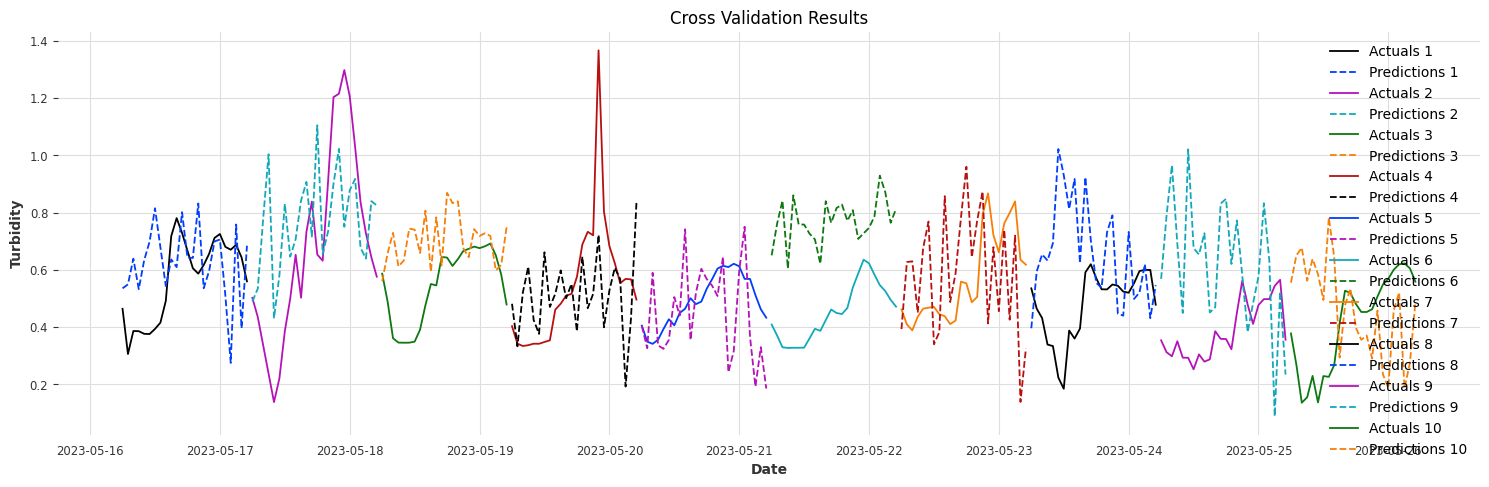

In [155]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(15, 5))

for i in range(len(cv)):
    # Inverse transform and convert to pandas.Series manually
    y_pred_unscaled = scaler1.inverse_transform(cv[i])
    predictions = pd.Series(
        y_pred_unscaled.values().flatten(),
        index=y_pred_unscaled.time_index
    )

    # Get actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = train_data.loc[start:end, 'y']

    # Plot actuals and predictions
    ax.plot(actuals, label=f'Actuals {i+1}')
    ax.plot(predictions, label=f'Predictions {i+1}', linestyle='--')

ax.legend()
ax.set_title('Cross Validation Results')
ax.set_xlabel('Date')
ax.set_ylabel('Turbidity')
plt.tight_layout()
plt.show()



# Parameter Tuning

In [156]:
from sklearn.model_selection import ParameterSampler

In [157]:
# define the parameter grid possibilities
param_gird = {
        'input_chunk_length': [1440],
        'num_stacks': [10],
        'num_blocks': [2],
        'num_layers': [2],
        'n_epochs':[5],
        'batch_size':[128],
        'layer_widths':[256]

}

In [158]:
# Define the fixed params
fixed_params = {
    'output_chunk_length': forecast_horizon,
    'add_encoders': add_encoders,
    'random_state': 42,
    'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}
}


In [159]:
# Number of random combinations to try
n_iter = 5

# Generate the random parameter conbinations
param_list = list(ParameterSampler(param_gird, n_iter=n_iter, random_state=42))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [160]:
param_list2 = param_list

for params in param_list:
  params.update(fixed_params)



In [161]:
total_rmse = []

for params in param_list:
    model = NBEATSModel(**params)

    # Cross-validation
    cv = model.historical_forecasts(
        series=y_transformed,
        past_covariates=past_covariates_transformed,
        forecast_horizon=forecast_horizon,
        start=train_data.shape[0] - (10 * forecast_horizon),
        stride=forecast_horizon,
        retrain=True,
        last_points_only=False,
    )

    rmse_cv = []

    for i in range(len(cv)):
        # Inverse transform a single TimeSeries
        y_pred_unscaled = scaler1.inverse_transform(cv[i])

        # Manually construct a pandas Series using values and time index
        predictions = pd.Series(
            y_pred_unscaled.values().flatten(),
            index=y_pred_unscaled.time_index)

        # Get actuals from original (unscaled) train_data
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = train_data.loc[start:end, 'y']

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        rmse_cv.append(rmse)

    # Store the mean RMSE for this parameter set
    mean_rmse = np.mean(rmse_cv)
    total_rmse.append(mean_rmse)
    print(f'The RMSE was {mean_rmse} with params {params}')

# Create results DataFrame
results = pd.DataFrame(param_list)
results['rmse'] = total_rmse
results = results.sort_values(by='rmse')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 92.0 M | train
-------------------------------------------------------------
91.8 M    Trainable params
104 K     Non-trainable params
92.0 M    Total params
367.816   Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


The RMSE was 41204644132485.266 with params {'num_stacks': 10, 'num_layers': 2, 'num_blocks': 2, 'n_epochs': 5, 'layer_widths': 256, 'input_chunk_length': 1440, 'batch_size': 128, 'output_chunk_length': 24, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'week', 'month', 'year']}, 'datetime_attribute': {'future': ['hour', 'day', 'week', 'month', 'year']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7d962f398ae0>], 'future': [<function encode_year at 0x7d962f398ae0>]}, 'transformer': Scaler, 'tz': 'CET'}, 'random_state': 42, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}


In [162]:
# best results
results = pd.DataFrame(param_list2)
results['rmse'] = total_rmse
results.sort_values(by='rmse')
results

,num_stacks,num_layers,num_blocks,n_epochs,layer_widths,input_chunk_length,batch_size,output_chunk_length,add_encoders,random_state,pl_trainer_kwargs,rmse
0,10,2,2,5,256,1440,128,24,"{'cyclic': {'future': ['hour', 'day', 'week', ...",42,"{'accelerator': 'gpu', 'devices': [0]}",4.120464e+13


In [100]:
results

,num_stacks,num_layers,num_blocks,n_epochs,layer_widths,input_chunk_length,batch_size,output_chunk_length,add_encoders,random_state,pl_trainer_kwargs,rmse
0,10,2,2,5,256,1440,128,5236,"{'cyclic': {'future': ['hour', 'day', 'week', ...",42,"{'accelerator': 'gpu', 'devices': [0]}",2.604589e+15


In [163]:
# export the best params
best_params = results.sort_values(by='rmse').iloc[0]
best_params.to_csv('best_params.csv')
best_params

,0
num_stacks,10
num_layers,2
num_blocks,2
n_epochs,5
layer_widths,256
input_chunk_length,1440
batch_size,128
output_chunk_length,24
add_encoders,"{'cyclic': {'future': ['hour', 'day', 'week', ..."
random_state,42


# Predict the future

In [26]:
from google.colab import files
uploaded = files.upload()

Saving best_params.xlsx to best_params.xlsx


In [30]:
best_params = pd.read_excel('best_params.xlsx')
best_params = best_params.drop(columns=['Unnamed: 0'])
best_params

KeyError: "['Unnamed: 0'] not found in axis"

In [29]:
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

{'params': {0: 'num_stacks',
  1: 'num_layers',
  2: 'num_blocks',
  3: 'n_epochs',
  4: 'layer_widths',
  5: 'input_chunk_length',
  6: 'batch_size',
  7: 'output_chunk_length'},
 'Number': {0: 10, 1: 2, 2: 2, 3: 5, 4: 256, 5: 1440, 6: 128, 7: 24}}

In [28]:
# load the best params
best_params = pd.read_csv('best_params.csv',index_col=0).drop(['rmse','add_encoders','random_state','pl_trainer_kwargs'])
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

KeyError: "['rmse', 'add_encoders', 'random_state', 'pl_trainer_kwargs'] not found in axis"

In [ ]:
# transform the best params into integers
for key, value in best_params_dict.items():
 best_params_dict[key] = int(value)

best_params_dict


In [ ]:
# add the fixed params
best_params_dict.update(fixed_params)

best_params_dict

In [ ]:
# build the tuned model
tuned_model = NBEATSModel(**best_params_dict)

tuned_model.fit(y_transformed,
        past_covariates=past_covariates_transformed)



In [ ]:
# load the test data
X_train = train_data.drop(columns=['y'])
X_test = test_data.drop(columns=['y'])
X = pd.concat([X_train, X_test])
covariates = TimeSeries.from_dataframe(X, freq='h')

covariates_transformed = scaler2.fit_transform(covariates)

In [ ]:
X

In [ ]:
covariates_transformed

In [ ]:
# forecast the future
forecast = tuned_model.predict(n=len(test_data),
                series = y_transformed,
                               past_covariates=covariates_transformed)

In [ ]:
forecast

In [ ]:
forecast_inv = scaler1.inverse_transform(forecast)
forecast_inv

In [ ]:
forecast_series = pd.Series(forecast_inv.values().flatten())
forecast

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_data['y'], label='Actuals')
ax.plot(forecast_series, label='Predictions', linestyle='--')
ax.set_title('N-BEATS forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Turbidity')
ax.legend()
plt.show()

In [ ]:
# Calculate metrics
mse = mean_squared_error(test_data['y'], forecast_series)
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_series))
mae = mean_absolute_error(test_data['y'], forecast_series)
mape = mean_absolute_percentage_error(test_data['y'], forecast_series)
r2 = r2_score(test_data['y'], forecast_series)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')
print(f'MSE: {mse}')

# Improvements


*   Explore the parameter tuning with a bigger width of parameter options -> requires time
*   Try some lagged regressors


*   Use a different model




